# N-gram Extraction in Python using NLTK

In [1]:
!pip install pandas matplotlib nltk PySastrawi --upgrade

- pandas: For reading and manipulating CSV data. It provides the DataFrame structure which makes it easy to preprocess and analyze text data.
- matplotlib: For plotting the frequencies of n-grams (bigrams and trigrams) as bar charts.
- nltk (Natural Language Toolkit): Includes several utilities such as the ngrams function to generate n-grams and the corpus of stopwords to filter out common words.
- re (Regular Expressions): Used to perform various text preprocessing tasks such as cleaning punctuation, handling number formats, and removing unwanted patterns.
- Sastrawi: A library developed for Indonesian language processing that provides a stemmer to reduce words to their base form (root words). This is crucial for handling text in Indonesian as it reduces variations of words to a standard form.

### Installing Libraries

In [2]:
import re
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd


import nltk
nltk.download('stopwords')

from nltk import ngrams
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

df = pd.read_csv("https://github.com/prospera-da/news-analysis/raw/refs/heads/main/data/news-watch-ketegangan%20perdagangan-sd-2024-01.csv")
df = df.drop_duplicates(subset=["keyword", "source", "link"])

df["content"] = df["content"].fillna("")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/datapros/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Preprocessing Text

The function preprocess_text(text) performs multiple steps to prepare the text for n-gram extraction:

- Case Folding: Converts all text into lowercase to ensure consistency.
- Number Normalization: Uses a regex to combine numbers with thousand separators (e.g., "1,000" or "1.000") into a single numeric string, removing extra characters.
- Punctuation Removal: Removes punctuation that might interfere with tokenizing words. The regex carefully avoids removing punctuation part of numeric values.
- Whitespace Normalization: Collapses multiple spaces into a single space.
- Removing Unwanted Phrases: Uses a list of phrases (such as "advertisement" or "scroll to continue with content") that are deemed unnecessary for analysis. These phrases are removed using case-insensitive regex matching.
- Date Removal: Removes date patterns specific to Indonesian date representations (days like “senin” or months like “januari”) with separate regex patterns.
- Tokenization: Splits the cleaned text on whitespace.
- Stopword Removal: Filters out common Indonesian stopwords using the nltk stopwords list.
- Stemming: Applies the Sastrawi stemmer to reduce each token to its root form, which is useful for grouping different forms of the same word together.

In [3]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words("indonesian"))


def preprocess_text(text):
    # Case folding: convert text to lowercase
    text = text.lower()

    # Combine numbers with thousand separators
    text = re.sub(
        r"\b(\d{1,3}(?:[.,]\d{3})+)\b",
        lambda m: m.group(0).replace(".", "").replace(",", ""),
        text,
    )

    # Remove punctuation using regex .,?!:;
    # This pattern matches punctuation that is not part of a number
    text = re.sub(r"(?<!\d)[^\w\s]|[^\w\s](?!\d)", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text)

    # Remove the specified unwanted phrases
    unwanted_phrases = [
        "advertisement",
        "scroll to continue with content",
        "cnbc indonesia",
        "kontan co id",
        "jakarta",
        "ihsg",
        "indeks harga saham gabungan",
        "year on year",
        # add more here
    ]
    for phrase in unwanted_phrases:
        # Use regex for case-insensitive replacement and to handle extra spaces
        pattern = re.compile(re.escape(phrase), re.IGNORECASE)
        text = pattern.sub("", text)

    # Remove date patterns
    date_patterns = [
        # Matches "selasa 5 11 2024", "senin 4 11", "5 11 2024", "5 11"
        r"\b(?:(?:senin|selasa|rabu|kamis|jumat|sabtu|minggu)\s+)?\d{1,2}\s+\d{1,2}(?:\s+\d{2,4})?\b",
        # Matches "januari 2024", "september 2024"
        r"\b(?:januari|februari|maret|april|mei|juni|juli|agustus|september|oktober|november|desember)\s+\d{4}\b",
    ]
    for pattern in date_patterns:
        text = re.sub(pattern, "", text)

    # Tokenize the text by splitting on whitespace
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens


def generate_ngrams(tokens, n):
    # Generate and join n-grams in one step
    ngrams_list = list(ngrams(tokens, n))
    return [" ".join(ngram) for ngram in ngrams_list]

Generating N-grams

The function generate_ngrams(tokens, n) uses nltk’s ngrams to generate a list of n-grams from a list of tokens. An n-gram is a contiguous sequence of n items from a given sample of text. For example:

- Bigrams: n = 2, e.g., "word1 word2"
- Trigrams: n = 3, e.g., "word1 word2 word3"

In [4]:
# Apply preprocessing and generate bigrams and trigrams
df["tokens"] = df["content"].apply(preprocess_text)
df["bigrams"] = df["tokens"].apply(lambda x: generate_ngrams(x, 2))
df["trigrams"] = df["tokens"].apply(lambda x: generate_ngrams(x, 3))

# Flatten lists and count frequencies
bigram_counts = Counter(bigram for sublist in df["bigrams"] for bigram in sublist)
trigram_counts = Counter(trigram for sublist in df["trigrams"] for trigram in sublist)

bigram_df = pd.DataFrame(
    bigram_counts.items(), columns=["bigram", "count"]
).sort_values(by="count", ascending=False)
trigram_df = pd.DataFrame(
    trigram_counts.items(), columns=["trigram", "count"]
).sort_values(by="count", ascending=False)

print("Top 10 Bigrams:")
print(bigram_df.head(10))

print("\nTop 10 Trigrams:")
print(trigram_df.head(10))

Top 10 Bigrams:
                 bigram  count
166872                   10849
16      amerika serikat   5468
436        donald trump   4987
238          suku bunga   3827
1791      perang dagang   3133
655       negara negara   2616
0            harga emas   2506
17           serikat as   2461
454          kena tarif   2450
490            dolar as   2432

Top 10 Trigrams:
                         trigram  count
253257                            10779
16            amerika serikat as   2456
467              as donald trump   1430
465     presiden amerika serikat   1200
5122          nilai tukar rupiah    934
252           mangkas suku bunga    829
5069        gambas video 20detik    708
2683          presiden as donald    679
2538            turun suku bunga    642
466            serikat as donald    624


<BarContainer object of 10 artists>

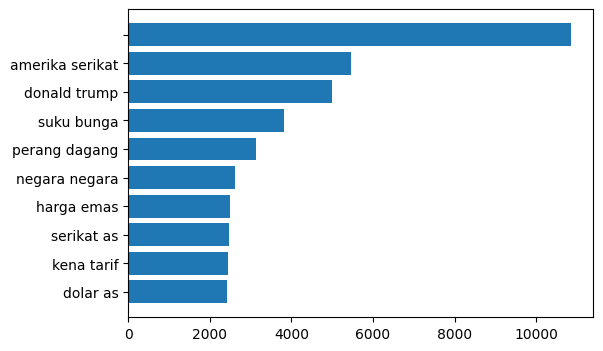

In [5]:
# Plotting the top 10 bigrams
plt.figure(figsize=(6, 4))
plt.barh(
    bigram_df["bigram"].head(10).iloc[::-1],
    bigram_df["count"].head(10).iloc[::-1],
)

<BarContainer object of 10 artists>

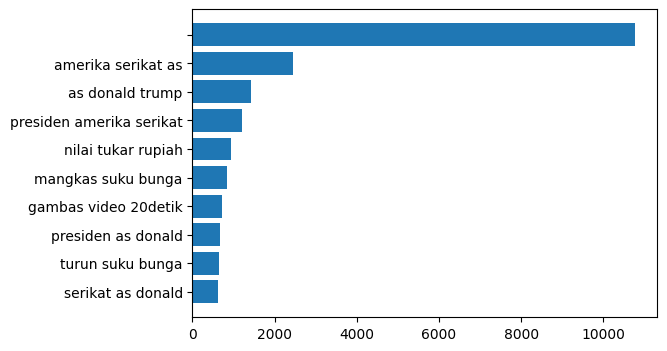

In [6]:
# Plotting the top 10 trigrams
plt.figure(figsize=(6, 4))
plt.barh(
    trigram_df["trigram"].head(10).iloc[::-1],
    trigram_df["count"].head(10).iloc[::-1],
)

In [7]:
# Save results
bigram_df.to_csv("news-bigrams.csv", index=False)
trigram_df.to_csv("news-trigrams.csv", index=False)

# News Article Clustering Tutorial

## 1. Environment Setup

In [8]:
!pip install openai pandas numpy scikit-learn kneed nest_asyncio python-dotenv tiktoken ipywidgets

## 2. Configuration Setup

In [9]:
import os
from dotenv import load_dotenv

load_dotenv(".env")


class Config:
    OPENAI_API_KEY = None  # set the key here or leave as None to use the one from .env
    EMBEDDING_MODEL = "text-embedding-3-small"
    LLM_MODEL = "gpt-4o"
    MAX_TOKENS = 8192
    CLUSTER_RANGE = range(2, 11)
    SEED = 42

    @classmethod
    def verify_key(cls):
        """Validate API key presence"""
        key = cls.OPENAI_API_KEY or os.getenv("OPENAI_API_KEY")
        if not key:
            raise ValueError("No API key found in Config or .env")
        return key


print(
    "Configuration loaded. Key status:",
    "✅ Valid" if Config.verify_key() else "❌ Missing",
)

Configuration loaded. Key status: ✅ Valid


## 3. Initialize Environment

In [10]:
import nest_asyncio
import numpy as np
import pandas as pd
from openai import AsyncOpenAI

# Async setup
nest_asyncio.apply()
aclient = AsyncOpenAI(api_key=Config.verify_key())

## 4. Data Loading

In [11]:
# Load dataset
file_name = "https://github.com/prospera-da/news-analysis/raw/refs/heads/main/data/news-watch-ketegangan%20perdagangan-sd-2024-01.csv"
df = pd.read_csv(file_name)

# Data preprocessing
df = df.drop_duplicates(subset=["keyword", "source", "link"])
df["content"] = df["content"].fillna("").astype(str)

df

,title,publish_date,author,content,keyword,category,source,link
0,"Sempat Terbang, Emas Hancur Bersama Mundurnya ...",2024-07-23 06:50:00,"Chandra Dwi,CNBC Indonesia","Jakarta, CNBC Indonesia\n- Harga emas ditutup ...",ketegangan perdagangan,Berita Research,cnbcindonesia.com,https://www.cnbcindonesia.com/research/2024072...
1,"Breaking! Harga Emas Tembus Rekor Baru, Mepet ...",2025-02-10 14:06:00,"mae,CNBC Indonesia","Jakarta, CNBC Indonesia\n- Harga emas tembus r...",tarif trump,Berita Research,cnbcindonesia.com,https://www.cnbcindonesia.com/research/2025021...
2,"Perdagangan Internasional: Pengertian, Manfaat...",2024-05-03 07:00:00,Nur Wasilatus Sholeha -detikEdu,Daftar Isi\nPengertian Perdagangan Internasion...,perang tarif,detikEdu,detik.com,https://www.detik.com/edu/detikedu/d-7321635/p...
3,"Serangan Israel Tidak Mempan ke Iran, Harga Mi...",2024-10-28 10:35:00,"Robertus Andrianto,CNBC Indonesia","Jakarta, CNBC Indonesia -\nHarga minyak mentah...",ketegangan perdagangan,Berita Market,cnbcindonesia.com,https://www.cnbcindonesia.com/market/202410280...
4,"7 Fakta Pemilu AS 2024, Siapa yang Dunia Mau J...",2024-11-05 15:05:00,"Tommy Patrio Sorongan,CNBC Indonesia","Jakarta, CNBC Indonesia\n-\nAmerika Serikat (A...",perang tarif,Berita,cnbcindonesia.com,https://www.cnbcindonesia.com/news/20241105144...
...,...,...,...,...,...,...,...,...
4436,"Isi Lengkap Perang Dagang 2.0 Trump, Tarif Ber...",2025-02-03 08:55:00,"Thea Fathanah Arbar,CNBC Indonesia","Jakarta, CNBC Indonesia\n- Presiden Amerika Se...",perang tarif,Berita,cnbcindonesia.com,https://www.cnbcindonesia.com/news/20250203075...
4437,"Bangga! Lewat Nikel, RI Bakal Punya Peran Stra...",2024-10-29 12:40:00,"Firda Dwi Muliawati,CNBC Indonesia","Jakarta, CNBC Indonesia -\nHolding BUMN Pertam...",perang tarif,Berita,cnbcindonesia.com,https://www.cnbcindonesia.com/news/20241029121...
4438,"Cegah Serbuan Produk China ke AS, Biden Mau Na...",2024-04-18 08:45:00,Aulia Damayanti -detikFinance,Jakarta\n-\nPresiden Amerika Serikat (AS) Joe ...,tarif China,detikFinance,detik.com,https://finance.detik.com/berita-ekonomi-bisni...
4439,Putar Otak Siasati Ancaman Perang Dagang AS-Ch...,2025-01-15 12:55:00,Amanda Christabel -detikFinance,Jakarta\n-\nPemerintah mengatakan kekhawatiran...,tarif AS,detikFinance,detik.com,https://finance.detik.com/berita-ekonomi-bisni...


## 5. Text Processing

In [12]:
import tiktoken


def safe_truncate(text: str) -> str:
    """Ensure text fits model's token limit"""
    enc = tiktoken.get_encoding("cl100k_base")
    tokens = enc.encode(text)[: Config.MAX_TOKENS]
    return enc.decode(tokens)


df["processed_content"] = df["content"].apply(safe_truncate)
df

,title,publish_date,author,content,keyword,category,source,link,processed_content
0,"Sempat Terbang, Emas Hancur Bersama Mundurnya ...",2024-07-23 06:50:00,"Chandra Dwi,CNBC Indonesia","Jakarta, CNBC Indonesia\n- Harga emas ditutup ...",ketegangan perdagangan,Berita Research,cnbcindonesia.com,https://www.cnbcindonesia.com/research/2024072...,"Jakarta, CNBC Indonesia\n- Harga emas ditutup ..."
1,"Breaking! Harga Emas Tembus Rekor Baru, Mepet ...",2025-02-10 14:06:00,"mae,CNBC Indonesia","Jakarta, CNBC Indonesia\n- Harga emas tembus r...",tarif trump,Berita Research,cnbcindonesia.com,https://www.cnbcindonesia.com/research/2025021...,"Jakarta, CNBC Indonesia\n- Harga emas tembus r..."
2,"Perdagangan Internasional: Pengertian, Manfaat...",2024-05-03 07:00:00,Nur Wasilatus Sholeha -detikEdu,Daftar Isi\nPengertian Perdagangan Internasion...,perang tarif,detikEdu,detik.com,https://www.detik.com/edu/detikedu/d-7321635/p...,Daftar Isi\nPengertian Perdagangan Internasion...
3,"Serangan Israel Tidak Mempan ke Iran, Harga Mi...",2024-10-28 10:35:00,"Robertus Andrianto,CNBC Indonesia","Jakarta, CNBC Indonesia -\nHarga minyak mentah...",ketegangan perdagangan,Berita Market,cnbcindonesia.com,https://www.cnbcindonesia.com/market/202410280...,"Jakarta, CNBC Indonesia -\nHarga minyak mentah..."
4,"7 Fakta Pemilu AS 2024, Siapa yang Dunia Mau J...",2024-11-05 15:05:00,"Tommy Patrio Sorongan,CNBC Indonesia","Jakarta, CNBC Indonesia\n-\nAmerika Serikat (A...",perang tarif,Berita,cnbcindonesia.com,https://www.cnbcindonesia.com/news/20241105144...,"Jakarta, CNBC Indonesia\n-\nAmerika Serikat (A..."
...,...,...,...,...,...,...,...,...,...
4436,"Isi Lengkap Perang Dagang 2.0 Trump, Tarif Ber...",2025-02-03 08:55:00,"Thea Fathanah Arbar,CNBC Indonesia","Jakarta, CNBC Indonesia\n- Presiden Amerika Se...",perang tarif,Berita,cnbcindonesia.com,https://www.cnbcindonesia.com/news/20250203075...,"Jakarta, CNBC Indonesia\n- Presiden Amerika Se..."
4437,"Bangga! Lewat Nikel, RI Bakal Punya Peran Stra...",2024-10-29 12:40:00,"Firda Dwi Muliawati,CNBC Indonesia","Jakarta, CNBC Indonesia -\nHolding BUMN Pertam...",perang tarif,Berita,cnbcindonesia.com,https://www.cnbcindonesia.com/news/20241029121...,"Jakarta, CNBC Indonesia -\nHolding BUMN Pertam..."
4438,"Cegah Serbuan Produk China ke AS, Biden Mau Na...",2024-04-18 08:45:00,Aulia Damayanti -detikFinance,Jakarta\n-\nPresiden Amerika Serikat (AS) Joe ...,tarif China,detikFinance,detik.com,https://finance.detik.com/berita-ekonomi-bisni...,Jakarta\n-\nPresiden Amerika Serikat (AS) Joe ...
4439,Putar Otak Siasati Ancaman Perang Dagang AS-Ch...,2025-01-15 12:55:00,Amanda Christabel -detikFinance,Jakarta\n-\nPemerintah mengatakan kekhawatiran...,tarif AS,detikFinance,detik.com,https://finance.detik.com/berita-ekonomi-bisni...,Jakarta\n-\nPemerintah mengatakan kekhawatiran...


## 6. Embedding Generation

In [13]:
import asyncio
from tqdm.notebook import tqdm
from openai import RateLimitError


async def generate_embeddings(
    texts: list, initial_delay: float = 1.0, max_delay: float = 60.0
) -> list:
    """Batch process embeddings with progress tracking and exponential backoff on rate-limit errors"""
    embeddings = []
    for i in tqdm(range(0, len(texts), 100), desc="Generating Embeddings"):
        batch = texts[i : i + 100]
        delay = initial_delay
        while True:
            try:
                results = await asyncio.gather(
                    *[
                        aclient.embeddings.create(input=t, model=Config.EMBEDDING_MODEL)
                        for t in batch
                    ]
                )
                break  # Success; exit the retry loop.
            except RateLimitError:
                print(f"Rate limit hit, waiting {delay} seconds and retrying...")
                await asyncio.sleep(delay)
                delay = min(delay * 2, max_delay)
        embeddings.extend([r.data[0].embedding for r in results])
    return embeddings


# Execute async embedding generation
df["embeddings"] = asyncio.run(generate_embeddings(df["processed_content"].tolist()))
print("Embeddings generated. Shape:", np.array(df["embeddings"].tolist()).shape)

Generating Embeddings:   0%|          | 0/44 [00:00<?, ?it/s]

Embeddings generated. Shape: (4383, 1536)


## 7. Clustering Setup

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

# Prepare embedding matrix
matrix = np.vstack(df["embeddings"].values)
print("Embedding matrix shape:", matrix.shape)

Embedding matrix shape: (4383, 1536)


In [15]:
# Calculate clustering metrics
inertias = []
silhouettes = []

for n in Config.CLUSTER_RANGE:
    kmeans = KMeans(n_clusters=n, random_state=Config.SEED).fit(matrix)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(matrix, kmeans.labels_))

# Auto-detect optimal clusters
knee = KneeLocator(
    Config.CLUSTER_RANGE, inertias, curve="convex", direction="decreasing"
)
optimal_clusters = knee.elbow or 5  # Fallback to 5 if not detected

print(
    f"Optimal clusters detected: {optimal_clusters} (Inertia: {inertias[optimal_clusters-2]:.2f})"
)

Optimal clusters detected: 7 (Inertia: 1652.91)


## 8. Cluster Visualization

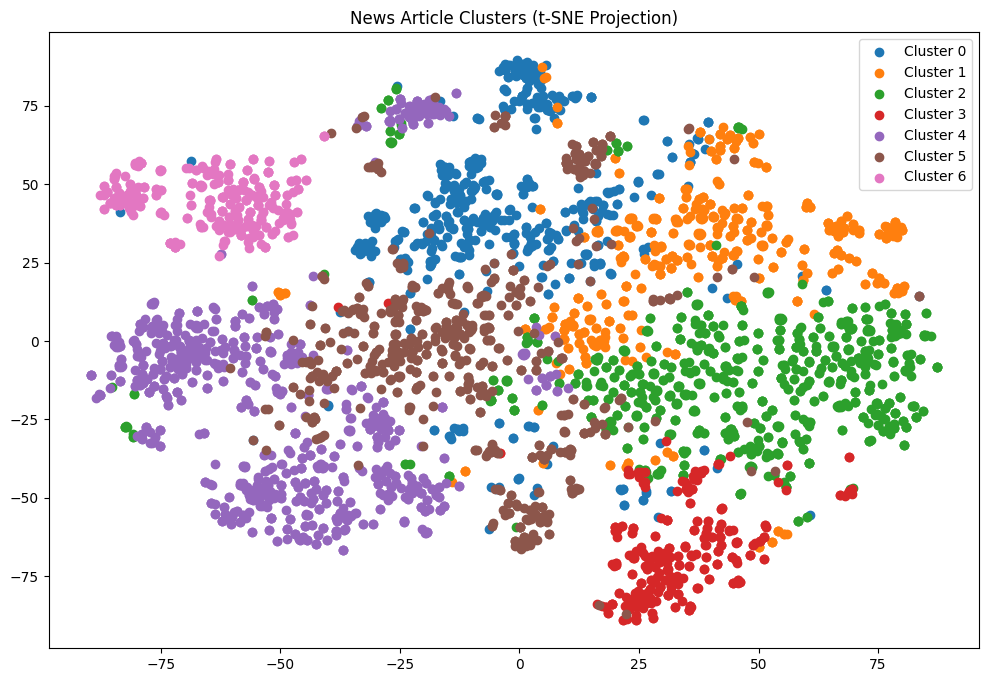

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Train final model
final_model = KMeans(n_clusters=optimal_clusters, random_state=Config.SEED)
df["cluster"] = final_model.fit_predict(matrix)

# Create t-SNE visualization
tsne = TSNE(n_components=2, random_state=Config.SEED)
vis_data = tsne.fit_transform(matrix)

plt.figure(figsize=(12, 8))
for cluster in range(optimal_clusters):
    plt.scatter(
        vis_data[df.cluster == cluster, 0],
        vis_data[df.cluster == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.legend()
plt.title("News Article Clusters (t-SNE Projection)")
plt.show()

## 9. Cluster Labeling

In [17]:
for i in range(optimal_clusters):
    print(f"News {i}:", end=" ")

    news = "\n".join(df[df.cluster == i].content.sample(5, random_state=42).values)
    messages = [
        {
            "role": "user",
            "content": f'Apa kesamaan dari berita-berita berikut ini? (Jawaban singkat (maks 7 kata), tanpa “Tema umum dalam berita-berita ini adalah")\n\nNews:\n"""\n{news}\n"""\n\nTheme:',
        }
    ]

    response = asyncio.run(
        aclient.chat.completions.create(
            model=Config.LLM_MODEL,
            messages=messages,
            temperature=0,
            max_tokens=1000,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
        )
    )

    # Extract the label from the response
    label = response.choices[0].message.content.replace("\n", "")

    # Assign the label to all rows in this cluster
    df.loc[df.cluster == i, "cluster_label"] = label

    print(label)
    sample_cluster_rows = df[df.cluster == i].sample(5, random_state=42)
    print("Berita:")
    for j in range(5):
        print(sample_cluster_rows.title.str[:100].values[j])

    print("-" * 100)

News 0: Peringatan dan peristiwa penting 18 Desember.
Berita:
Sederet Peringatan 18 Desember, Ada Hari Jadi Kabupaten Banyuwangi
Whoosh Buka Rute Baru Padalarang-Tegalluar, Tarif Rp 50 Ribu
Berebut Minyak "Tanah Suci"
Keluhkan Perang Tarif, 2.500 Ojol dan Kurir se-Jabodetabek Demo Hari Ini!
Terbongkar! Ini Biang Kerok yang Bikin Tiket Pesawat Jadi Mahal Banget
----------------------------------------------------------------------------------------------------
News 1: Kebijakan Donald Trump dan dampaknya.
Berita:
Trump Ancam Tambah Sanksi Terkait Perang Ukraina, Rusia Bilang Begini
Daftar 9 Kepala Negara yang Untung-Rugi Trump Jadi Presiden AS Lagi
Resmi! Trump Balik Lagi ke X, Singgung Kamala, Xi Jinping, NATO & PD 3
Bos BI Wanti-wanti Kondisi AS Bikin Dunia Makin 'Gelap'
Video: Trump Siap Umumkan Tarif Impor Balasan ke Banyak Negara
----------------------------------------------------------------------------------------------------
News 2: Tarif perdagangan dan kebijakan Donald Trump.

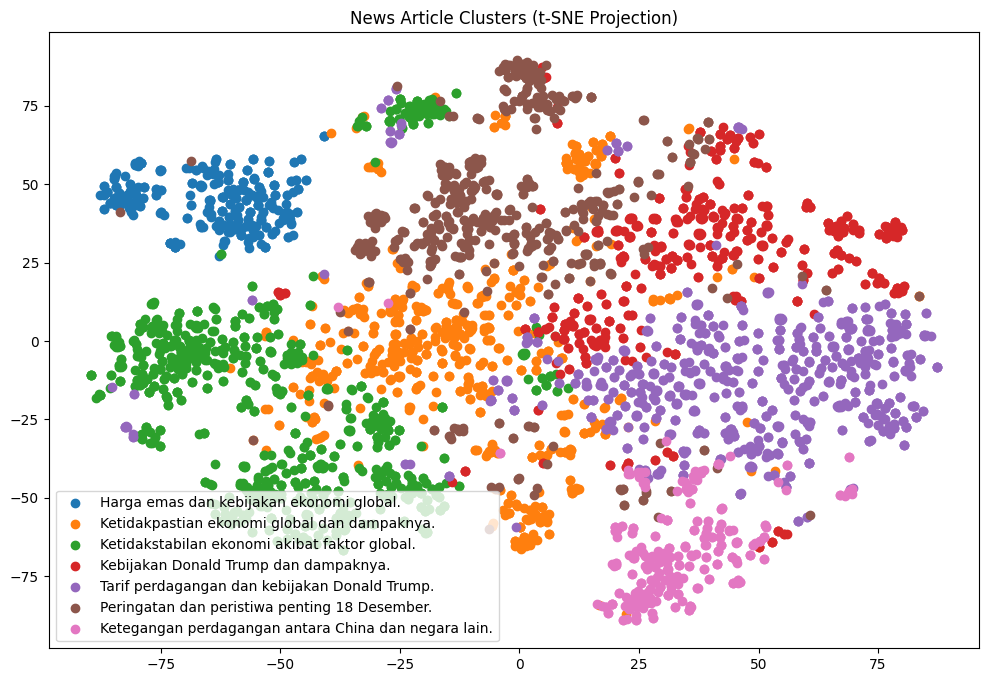

In [18]:
plt.figure(figsize=(12, 8))
for label in df["cluster_label"].unique():
    mask = df["cluster_label"] == label
    plt.scatter(vis_data[mask, 0], vis_data[mask, 1], label=label)
plt.legend()
plt.title("News Article Clusters (t-SNE Projection)")
plt.show()

<Axes: xlabel='publish_date'>

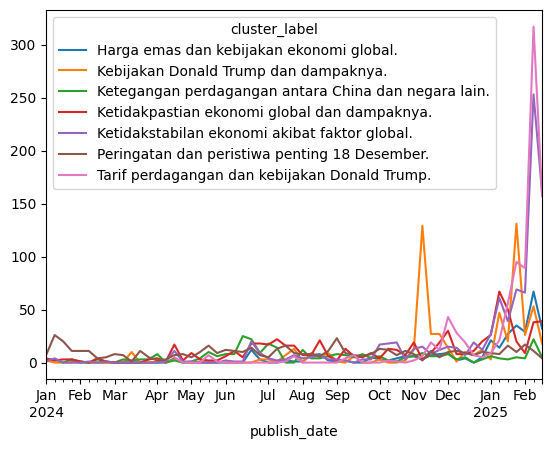

In [26]:
df["publish_date"] = pd.to_datetime(df["publish_date"])
df.groupby("cluster_label").resample("W", on="publish_date").size().unstack(0).plot()

<Axes: ylabel='cluster_label'>

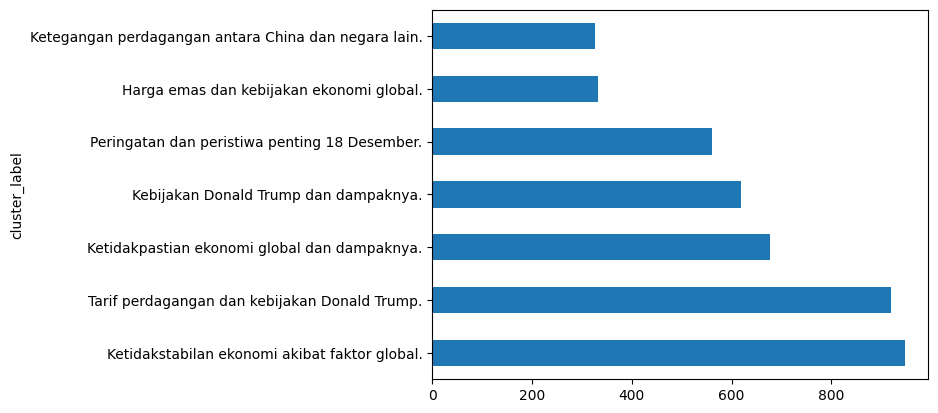

In [28]:
df["cluster_label"].value_counts().plot(kind="barh")

## Save Results

In [19]:
df["x"] = vis_data[:, 0]
df["y"] = vis_data[:, 1]

In [20]:
df.drop("embeddings", axis=1).to_csv("tableau.csv")